In [2]:
import pandas as pd 
import sys 

sys.path.append('../../')
import helpers.data_helpers as data_helpers
import datetime
import pytz
import numpy as np 
import matplotlib.pyplot as plt
import backtesting 
from backtesting import Backtest, Strategy 

In [3]:
raw_model = pd.read_csv("../../data/vol_models/BTCUSDT_90mill.csv")
vol_model = raw_model.dropna().copy()
vol_model['Open Time'] = pd.to_datetime(vol_model['Open Time'])
vol_model = vol_model.set_index('Open Time')
    

In [4]:


df = vol_model.loc['2022-01-01':].copy()
df['range'] = (df['Close'] - df['Open']) / df['Open']

two_hour_candle = df.copy().resample(f"2H").agg(
        {
            "Open": "first",
            "High": "max",
            "Low": "min",
            "Close": "last",
        }
    )
two_hour_candle['range'] = (two_hour_candle['High'] - two_hour_candle['Low']) / two_hour_candle['Open']
average_value = two_hour_candle['range'].mean()
top_threshold_value = two_hour_candle['range'].quantile(0.25)

two_hour_candle['rolling_range'] = two_hour_candle['range'].rolling(window=6).mean().shift(1)
average_value = two_hour_candle['rolling_range'].mean()
top_threshold_value = two_hour_candle['rolling_range'].quantile(0.25)

# print(two_hour_candle)
print(f"Average Value {average_value}")
print(f"50% Mark {top_threshold_value}")

mapping = df.index.to_series().dt.floor('2H')

# Map the rolling_range from the two-hour candle DataFrame to the minute candle DataFrame
df['two_hour_rolling_range'] = mapping.map(two_hour_candle['rolling_range'])

df= df.dropna()

print(df)


Average Value 0.011237543383863752
50% Mark 0.006497137284754328
                         Open      High       Low     Close   Volume  \
Open Time                                                              
2022-01-01 12:00:00  46755.01  46828.75  46755.01  46820.13  148.535   
2022-01-01 12:01:00  46820.12  46824.56  46798.15  46807.20   87.133   
2022-01-01 12:02:00  46807.19  46809.96  46762.27  46807.53  156.530   
2022-01-01 12:03:00  46807.53  46816.35  46790.29  46796.53   56.601   
2022-01-01 12:04:00  46796.53  46827.99  46793.94  46805.22   49.626   
...                       ...       ...       ...       ...      ...   
2023-12-11 20:21:00  40749.60  40759.00  40710.00  40716.60  189.927   
2023-12-11 20:22:00  40716.50  40726.30  40650.00  40726.20  408.432   
2023-12-11 20:23:00  40726.30  40729.10  40652.80  40675.10  268.130   
2023-12-11 20:24:00  40675.00  40714.30  40632.20  40637.40  467.219   
2023-12-11 20:25:00  40636.00  40669.80  40612.00  40669.80  267.514   

Start                     2022-01-01 12:00:00
End                       2023-12-01 23:59:00
Duration                    699 days 11:59:00
Exposure Time [%]                   61.997955
Equity Final [$]              148415403.59398
Equity Peak [$]              226652204.414413
Return [%]                          48.415404
Buy & Hold Return [%]              -17.428679
Return (Ann.) [%]                   22.860998
Volatility (Ann.) [%]                91.05885
Sharpe Ratio                         0.251057
Sortino Ratio                        0.478037
Calmar Ratio                         0.375058
Max. Drawdown [%]                  -60.953257
Avg. Drawdown [%]                   -1.246937
Max. Drawdown Duration      530 days 18:34:00
Avg. Drawdown Duration        1 days 17:16:00
# Trades                                 3099
Win Rate [%]                        59.051307
Best Trade [%]                       4.354393
Worst Trade [%]                     -7.160263
Avg. Trade [%]                    

c:\blockforce\quant-lab\research\volatility\../..\helpers\data_helpers.py:234: RuntimeWarning: invalid value encountered in longlong_scalars
  positive_rowcount / (positive_rowcount + negative_rowcount)


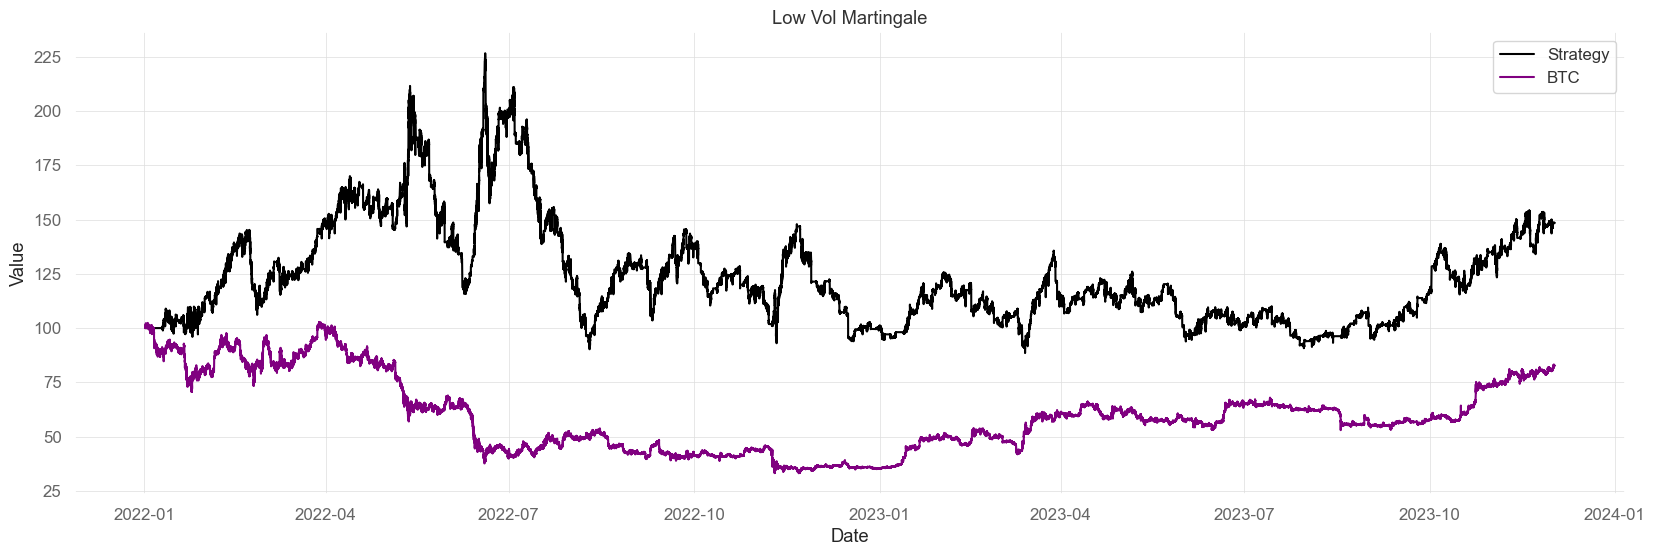

In [5]:
"""
Lets do position manager entry style. And you enter in a red period, exit when it turns green 
You enter long or short based off 20 period and 50 period SMA (on 4 hour candles) 4800 min and 12000
Lets start with regular position manager 80 bps down and then add 1/6 1/3 1/2 or maybe we do less initial 
Next step could be changing the 80 bps to something market determined
"""
def SMA(values, n):
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return pd.Series(values).rolling(n).mean()

class PMvol(Strategy):
    
    LEVERAGE_STATS = {0:0, 1:.5, 2: 1.5, 3:2}
    TRADE_SIZES = {0: .25, 1: .666, 2: .99, 3: .99, 4:0}
    # TRADE_SIZES = {0: .5, 1: .5, 2: .99, 3: .99, 4:0}

    MAX_TRADES = 3
   
    # TRADE_SIZES = {0: .5, 1: .99, 2: .4, 3: .99, 4:0}
    # MAX_TRADES = 2
    TP= .003
    SL = -.05
    MAX_TP = .008
    ADD_THRESH = -.006
    
    n1 = 20*60*4
    n2 = 50*60*4
    
    def _atr(self):
        return self.data.two_hour_rolling_range
    
    def _vol(self):
        return self.data.cross
    
    def init(self):
        super().init()
        self.atr = self.I(self._atr)
        self.vol = self.I(self._vol)

        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def bars_since_first_trade(self):
        if len(self.trades) > 0:
            first_trade_entry_bar = self.trades[0].entry_bar
            bars_since_first_trade = len(self.data.Close) - first_trade_entry_bar
            return bars_since_first_trade
        else:
            return 0
    
    def create_trailing_tp(self, action, size, trailing_tp_pct, tp_pct):
        direction = None
        # first execute initial trade
        if action == "buy":
            self.buy(size=size)
            direction = "long"
        elif action == "sell":
            self.sell(size=size)
            direction = "short"

        self.trailing_tp = {
            "order_status": "just_created",
            "direction": direction,
            "entry_price": None,
            "floor_ceiling_price": None,
            "num_orders": 1,
            "trailing_tp_pct": trailing_tp_pct,
            "tp_pct": tp_pct,
        }

    def initialize_tp(self):
        total_size = 0
        total_value = 0
        # get average trade price
        for trade in self.trades:
            # print(f'Past Trade {trade.size} {trade.value}')
            total_size += abs(trade.size)
            total_value += abs(trade.size) * trade.entry_price

        average_price = total_value / total_size

        self.trailing_tp["entry_price"] = average_price
        self.trailing_tp["order_status"] = "happening"

    def maintain_trailing_tp(self):
        
        if self.trailing_tp["order_status"] == "happening":
            
            if self.position.pl_pct > self.trailing_tp["tp_pct"]:
                
                # put in floor order
                if self.trailing_tp["direction"] == "long":
                    if self.trailing_tp["num_orders"] > 1:
                        for order in self.orders:
                            order.cancel()
                    potential_new_floor_price = self.data.Close * (
                        1 - self.trailing_tp["trailing_tp_pct"]
                    )
                    if self.trailing_tp["floor_ceiling_price"] is None:
                        floor_price = potential_new_floor_price
                    else:
                        floor_price = max(
                            potential_new_floor_price,
                            self.trailing_tp["floor_ceiling_price"],
                        )
                    self.sell(size=self.position.size, stop=floor_price)
                    self.trailing_tp["num_orders"] += 1

                if self.trailing_tp["direction"] == "short":
                    if self.trailing_tp["num_orders"] > 1:
                        for order in self.orders:
                            order.cancel()

                    potential_new_ceiling_price = self.data.Close * (
                        1 + self.trailing_tp["trailing_tp_pct"]
                    )
                    if self.trailing_tp["floor_ceiling_price"] is None:
                        ceiling_price = potential_new_ceiling_price
                    else:
                        ceiling_price = min(
                            potential_new_ceiling_price,
                            self.trailing_tp["floor_ceiling_price"],
                        )
                    self.buy(size=abs(self.position.size), stop=ceiling_price)
                    self.trailing_tp["num_orders"] += 1
    
    def set_signal(self):
        self.latest_signal_time = self.data.index[-1]
        self.latest_signal = self.signal

    def next(self):
        super().next()

        if not self.position:

            if self.vol[-1] == -1:
                if self.sma1 > self.sma2:
                    self.buy(size=self.TRADE_SIZES[0])
                else:
                    self.sell(size=self.TRADE_SIZES[0])
        # print(self.atr[-1])
        if self.position:
            # print(f'Last Trade {self.trades[-1].pl_pct} Add Thresh {self.ADD_THRESH}')
            if self.vol[-1] == 1:
                self.position.close()

            if self.position.pl_pct * self.LEVERAGE_STATS[len(self.trades)] < self.SL:
                # print('STOP LOSS BITCHHHHHHH')
                self.position.close()

            
            elif self.position.is_long and self.sma1[-1] < self.sma2[-1]:
                # print(f'Cross {round(self.position.pl_pct, 4)}')
                self.position.close()
            elif self.position.is_short and self.sma1[-1] > self.sma2[-1]:
                # print(f'Cross {round(self.position.pl_pct, 4)}')
                self.position.close()
            
            
            elif self.trades[-1].pl_pct < -(self.atr[-1]) and len(self.trades) < self.MAX_TRADES:
                # print(f"added {self.atr[-1]}")
                if self.position.is_long:
                    self.buy(size=self.TRADE_SIZES[len(self.trades)])
                else:
                    self.sell(size=self.TRADE_SIZES[len(self.trades)])

            # elif self.trades[-1].pl_pct < self.ADD_THRESH and len(self.trades) == self.MAX_TRADES:
            #     print(f'new stop loss {self.position.pl_pct*self.LEVERAGE_STATS[len(self.trades)]}')
            #     self.position.close()

            elif self.position.pl_pct > (self.atr[-1] /2):
                # print(f"Tp {self.atr[-1] /2}")
                self.position.close()
    
        

bt_start = '2022-01-01'
bt_end = '2023-12-01'

bt_data = df.copy()


# print(bt_data.loc[bt_start:bt_end])
bt = Backtest(
    bt_data.loc[bt_start:bt_end],
    PMvol,
    cash=100_000_000,
    trade_on_close=False,
    commission=0.0005,
    exclusive_orders=False,
    margin=.25,  # Set this to 0.5 for 2x leverage, 0.25 for 4x leverage, 0.125 for 8x leverage, etc.
)

stat = bt.run()
print(stat)

cleaned_trades = data_helpers.calc_acc_stats(stat['_trades'], 100_000_000)

# print(stat['_trades'].to_markdown())

# Plot the Close, SMA, and EMA
eq_curve = stat['_equity_curve'] / 1000000
daily_df = eq_curve.resample('D').last()
# daily_df.to_csv(f'../../outputs/equitycurve/90mvol_low_vol_sma_martingale_no_leverage.csv')




# print(eq_curve.loc[].to_markdown())

plot_sample = eq_curve.loc[bt_start:bt_end].copy()
plot_sample_btc = bt_data.loc[bt_start:bt_end].copy()

plot_sample_btc['Normalized Price'] = plot_sample_btc['Close'] / plot_sample_btc['Close'].iloc[0] * 100

plt.figure(figsize=(20, 6))
plt.plot(plot_sample.index, plot_sample['Equity'], label='Strategy', color = 'black')
plt.plot(plot_sample_btc.index, plot_sample_btc['Normalized Price'], label='BTC', color = 'purple')
# Set labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Low Vol Martingale')
plt.legend()


ATR Window = 12
Start                     2022-01-02 00:00:00
End                       2023-12-01 23:59:00
Duration                    698 days 23:59:00
Exposure Time [%]                   61.990542
Equity Final [$]                 308037165.26
Equity Peak [$]                  311379969.86
Return [%]                         208.037165
Buy & Hold Return [%]              -18.992897
Return (Ann.) [%]                   79.943476
Volatility (Ann.) [%]               57.086478
Sharpe Ratio                         1.400392
Sortino Ratio                        3.657241
Calmar Ratio                         3.214747
Max. Drawdown [%]                  -24.867733
Avg. Drawdown [%]                   -0.398981
Max. Drawdown Duration       79 days 03:57:00
Avg. Drawdown Duration        0 days 11:40:00
# Trades                                 2826
Win Rate [%]                        60.969568
Best Trade [%]                       3.964758
Worst Trade [%]                    -10.491214
Avg. Trade [%]                        0.05608
Max. Trade Duration           2 days 07:45:00
Avg. Trade Duration           0 days 05:02:00
Profit Factor                        1.190759
Expectancy [%]                       0.061112
SQN                                  3.450837
_strategy                               PMvol
_equity_curve                             ...
_trades                         Size  Entr...

ATR Window = 6
Start                     2022-01-01 12:00:00
End                       2023-12-01 23:59:00
Duration                    699 days 11:59:00
Exposure Time [%]                   61.996565
Equity Final [$]                 375038407.63
Equity Peak [$]              379544897.130001
Return [%]                         275.038408
Buy & Hold Return [%]              -17.428679
Return (Ann.) [%]                   99.223009
Volatility (Ann.) [%]               67.779247
Sharpe Ratio                         1.463914
Sortino Ratio                        4.309033
Calmar Ratio                         3.420853
Max. Drawdown [%]                  -29.005345
Avg. Drawdown [%]                   -0.353836
Max. Drawdown Duration       91 days 04:22:00
Avg. Drawdown Duration        0 days 09:49:00
# Trades                                 3281
Win Rate [%]                        62.267601
Best Trade [%]                       4.402215
Worst Trade [%]                    -10.491214
Avg. Trade [%]                       0.055212
Max. Trade Duration           2 days 07:45:00
Avg. Trade Duration           0 days 04:36:00
Profit Factor                        1.200456
Expectancy [%]                       0.059744
SQN                                  4.141374
_strategy                               PMvol
_equity_curve                             ...
_trades                         Size  Entr...

ATR window = 3
Start                     2022-01-01 06:00:00
End                       2023-12-01 23:59:00
Duration                    699 days 17:59:00
Exposure Time [%]                   61.991187
Equity Final [$]             343529990.950001
Equity Peak [$]              351047893.850001
Return [%]                         243.529991
Buy & Hold Return [%]              -18.054452
Return (Ann.) [%]                   90.312488
Volatility (Ann.) [%]                66.99797
Sharpe Ratio                         1.347988
Sortino Ratio                        3.659852
Calmar Ratio                         2.843939
Max. Drawdown [%]                  -31.756126
Avg. Drawdown [%]                   -0.357677
Max. Drawdown Duration      154 days 16:20:00
Avg. Drawdown Duration        0 days 10:18:00
# Trades                                 3715
Win Rate [%]                        64.010767
Best Trade [%]                       3.964758
Worst Trade [%]                    -10.491214
Avg. Trade [%]                       0.048538
Max. Trade Duration           2 days 10:45:00
Avg. Trade Duration           0 days 04:19:00
Profit Factor                        1.187162
Expectancy [%]                       0.052745
SQN                                  3.682863
_strategy                               PMvol
_equity_curve                             ...
_trades                         Size  Entr...

This is 4H ATR 

Window = 3
Start                     2022-01-01 12:00:00
End                       2023-12-01 23:59:00
Duration                    699 days 11:59:00
Exposure Time [%]                   61.997756
Equity Final [$]                 223862570.61
Equity Peak [$]                  225498255.11
Return [%]                         123.862571
Buy & Hold Return [%]              -17.428679
Return (Ann.) [%]                    52.22653
Volatility (Ann.) [%]               41.905942
Sharpe Ratio                          1.24628
Sortino Ratio                         2.73857
Calmar Ratio                         1.788992
Max. Drawdown [%]                  -29.193277
Avg. Drawdown [%]                   -0.342906
Max. Drawdown Duration      294 days 06:00:00
Avg. Drawdown Duration        0 days 15:52:00
# Trades                                 2299
Win Rate [%]                        59.765115
Best Trade [%]                       5.502608
Worst Trade [%]                    -10.491214
Avg. Trade [%]                       0.051087
Max. Trade Duration           2 days 16:11:00
Avg. Trade Duration           0 days 05:46:00
Profit Factor                        1.165447
Expectancy [%]                       0.056699
SQN                                  2.830965
_strategy                               PMvol

Window = 6
Start                     2022-01-02 00:00:00
End                       2023-12-01 23:59:00
Duration                    698 days 23:59:00
Exposure Time [%]                   61.992529
Equity Final [$]                 201178476.22
Equity Peak [$]                  201823868.62
Return [%]                         101.178476
Buy & Hold Return [%]              -18.992897
Return (Ann.) [%]                   44.053076
Volatility (Ann.) [%]               38.058704
Sharpe Ratio                         1.157503
Sortino Ratio                        2.461453
Calmar Ratio                         1.628534
Max. Drawdown [%]                  -27.050761
Avg. Drawdown [%]                    -0.34098
Max. Drawdown Duration      414 days 15:54:00
Avg. Drawdown Duration        0 days 20:07:00
# Trades                                 2000
Win Rate [%]                            58.95
Best Trade [%]                       4.826038
Worst Trade [%]                    -10.491214
Avg. Trade [%]                       0.053043
Max. Trade Duration           2 days 16:11:00
Avg. Trade Duration           0 days 06:13:00
Profit Factor                        1.160843
Expectancy [%]                       0.059285
SQN                                  2.480132
_strategy                               PMvol
_equity_curve                             ...
_trades                         Size  Entr...